In [1]:
import os
import copy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.linestyle": "--"})

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import GATv2Conv # Using GATv2 from https://arxiv.org/abs/2105.14491
from torch_geometric.nn import global_mean_pool, global_sort_pool
#from torch.utils.data import random_split
from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

# verify installation in rustenv
import torch_geometric
print(torch_geometric.__version__)

2.6.1


### How to generate dataset.
- Install Rust (https://www.rust-lang.org/learn/get-started)
- Edit line 19 of tree_gen/src/main.rs which defines the constant MIN_BRANCH_LEN ; 
    - set it to 4.0 if using the mode as minimum branch length, and leave it as 7.7 if using mean as minimum branch length

- May have to install dependencies: 
```
sudo apt-get install libexpat1-dev zlib1g-dev libbz2-dev libpng-dev libbrotli-dev
```
- In a terminal, from the home directory, run:

```
            cargo run -p tree_gen --release -- 1000000
```
- 1000000 can be changed to any other number to generate more trees or fewer trees
- This will generate both CNN and GAT datasets, in cnn/dataset and gat/dataset respectively.
-If a dataset already exists at either of these locations it will simply append to the existing one. 

In [2]:
data_paths =  os.listdir("./gat/dataset/")
data_paths = [file for file in data_paths if file != "labels.txt"] # exlude labels file

# labels
labels = {}
with open("./gat/dataset/labels.txt", "r") as label_file:
    for line in label_file:
        filename, label = line.strip().split(", ")
        labels[filename] = int(label)


sample_labels = dict(list(labels.items())[:5])
print(sample_labels)

{'1729713575783562379.txt': 1, '1729713575784289651.txt': 3, '1729713575784210367.txt': 7, '1729713575783559543.txt': 2, '1729713575784129860.txt': 9}


Data for 1729713886205280428.txt:
Data(x=[423, 4], edge_index=[2, 422])




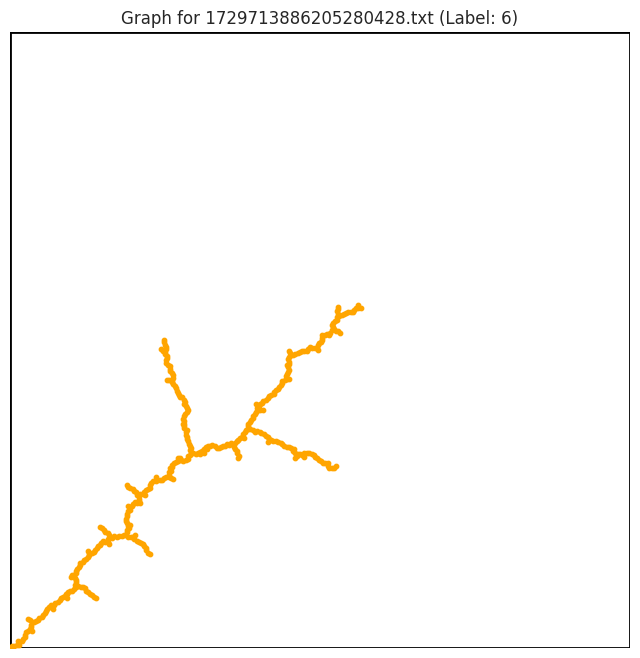

Data for 1729713589918405226.txt:
Data(x=[711, 4], edge_index=[2, 710])




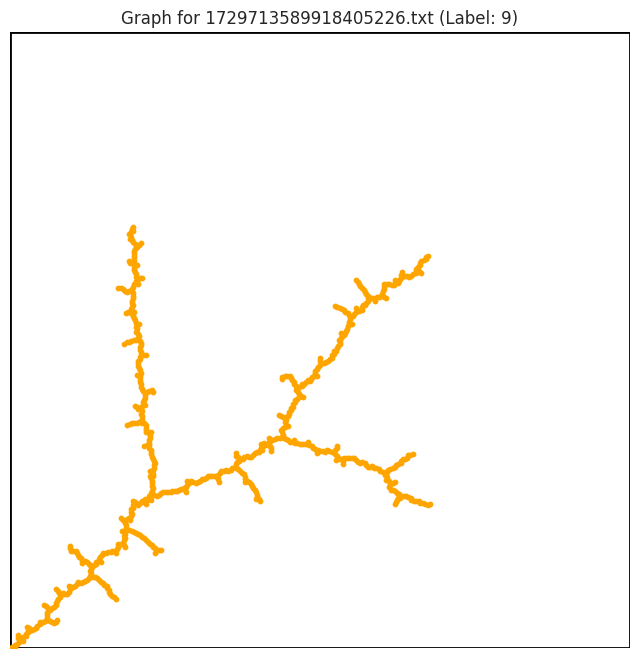

Data for 1729713831446398242.txt:
Data(x=[231, 4], edge_index=[2, 230])




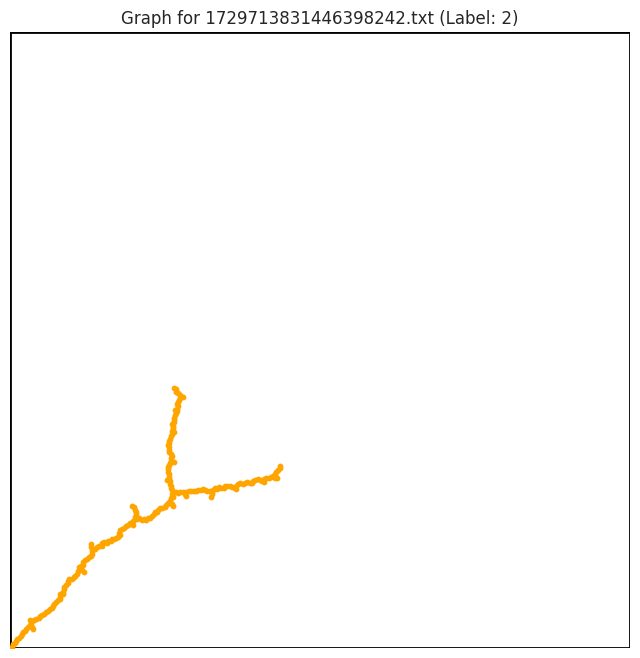

In [3]:
# load sample data
# Features are: node id, parent id, distance to parent, x_coordinate, y_coordinate, degree 
sample_data_path = data_paths[0:3]
# Define fixed figure size and axis limits
fig_size = (8, 8)
x_min, x_max = 0, 250  
y_min, y_max = 0, 250 

for data_path in sample_data_path:
    with open("gat/dataset/" + data_path, "r") as data:
        lines = data.readlines()
        
    nodes = []
    edges = []
    
    for line in lines:
        node_data = line.strip().split(',')
        node_id, parent_id = map(int, node_data[:2])
        distance_to_parent, x, y, degree = map(float, node_data[2:])
        
        nodes.append((node_id, [distance_to_parent, x, y, degree]))
        if parent_id != -1:  # Exclude root node which has no parent
            edges.append((parent_id, node_id))
    
    # Create PyTorch Geometric Data object
    x = torch.tensor([features for _, features in sorted(nodes)], dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    data = Data(x=x, edge_index=edge_index)
    print(f"Data for {data_path}:")
    print(data)
    print("\n")
    
    # Create a NetworkX graph
    G = nx.Graph()
    G.add_edges_from(edges)
    
    # Extract x and y coordinates
    pos = {node_id: (features[1], features[2]) for node_id, features in nodes}
    
    # Plot 
    fig, ax = plt.subplots(figsize=fig_size)
    nx.draw(G, pos, ax=ax, with_labels=False, node_color='orange', 
            node_size=10, edge_color='green')
    
    # label for the current data_path
    label = labels.get(data_path, "Unknown")
    
    plt.title(f"Graph for {data_path} (Label: {label})")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # boundary box
    ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                               fill=False, edgecolor='black', linewidth=2))
    
    plt.show()

#The graphs are too dense for the edges to be visible. 



Class 0: 17249
Class 1: 104750
Class 2: 83656
Class 3: 74005
Class 4: 75146
Class 5: 81860
Class 6: 84845
Class 7: 83279
Class 8: 77705
Class 9: 71463
Class 10: 63843
Class 11: 54876
Class 12: 44641
Class 13: 33753
Class 14: 22552
Class 15: 13713
Class 16: 7182
Class 17: 3466
Class 18: 1406
Class 19: 427
Class 20: 129
Class 21: 35
Class 22: 14
Class 23: 3
Class 24: 2

Total number of classes: 25


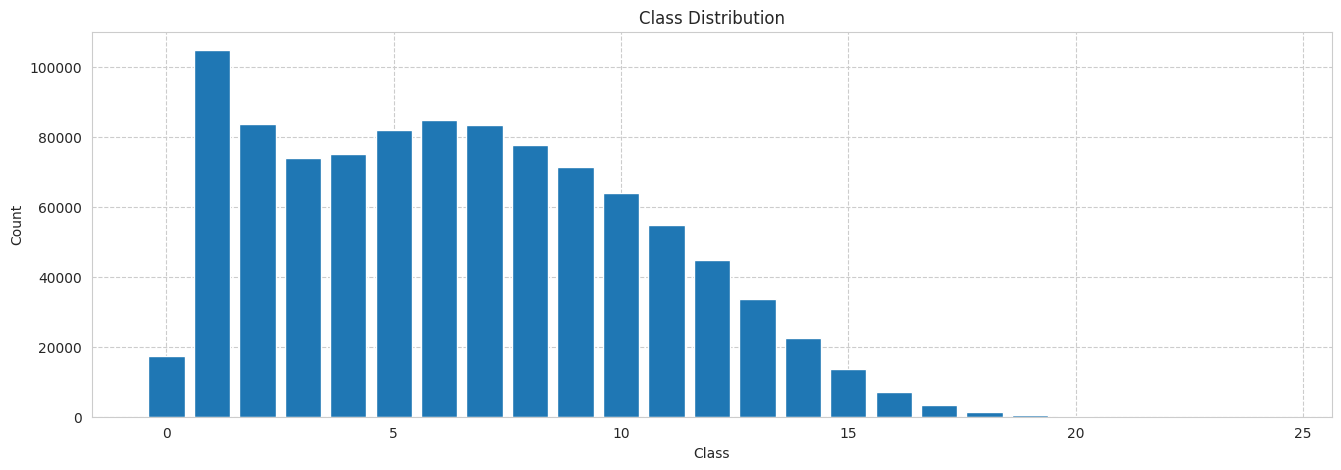

In [4]:
# Analysis of class distribution. Number of classes. Names of the classes.
class_distribution = {}

for data_path in data_paths:
    label = labels.get(data_path, "Unknown")
    if label in class_distribution:
        class_distribution[label] += 1
    else:
        class_distribution[label] = 1

# Sort the class distribution by class label
sorted_distribution = dict(sorted(class_distribution.items()))

# Print the sorted class distribution
for label, count in sorted_distribution.items():
    print(f"Class {label}: {count}")

# Print total number of classes
print(f"\nTotal number of classes: {len(sorted_distribution)}")

fig, ax = plt.subplots(figsize=(16, 5))
ax.bar(class_distribution.keys(), class_distribution.values())
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.show()

Updated class distribution:
Class 0: 17249
Class 1: 104750
Class 2: 83656
Class 3: 74005
Class 4: 75146
Class 5: 81860
Class 6: 84845
Class 7: 83279
Class 8: 77705
Class 9: 71463
Class 10: 63843
Class 11: 54876
Class 12: 44641
Class 13: 33753
Class 14: 22552

Total number of classes after filtering: 15
Total number of samples after filtering: 973623


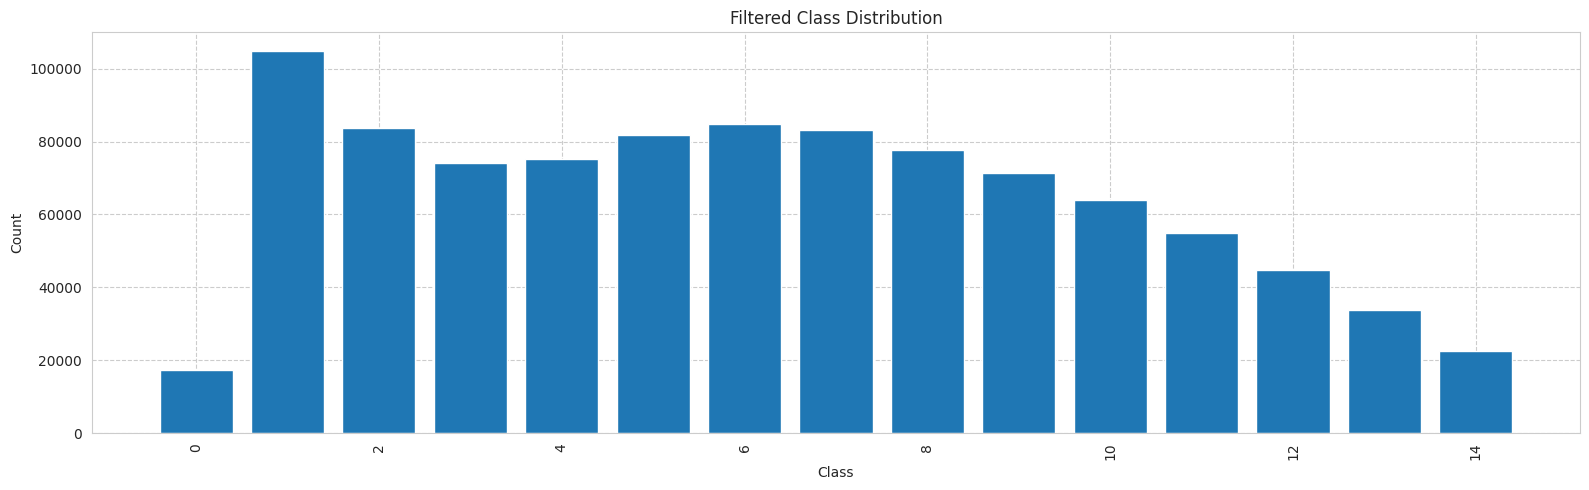

In [5]:
# Remove data with labels greater than 59.
# Although the class 0 also has small number of data points, it's important to keep it.

filtered_data_paths = []
filtered_labels = {}

NUM_CLASSES = 15 
NUM_FEATURES = 4

for data_path in data_paths:
    label = labels.get(data_path, "Unknown")
    if isinstance(label, (int, float)) and label < NUM_CLASSES: # Equals to creates a problem for class 0
        filtered_data_paths.append(data_path)
        filtered_labels[data_path] = label

data_paths = filtered_data_paths
labels = filtered_labels

class_distribution = {}
for label in labels.values():
    if label in class_distribution:
        class_distribution[label] += 1
    else:
        class_distribution[label] = 1

print("Updated class distribution:")
for label, count in sorted(class_distribution.items()):
    print(f"Class {label}: {count}")

print(f"\nTotal number of classes after filtering: {len(class_distribution)}")
print(f"Total number of samples after filtering: {len(data_paths)}")

# Plot the filtered distribution
fig, ax = plt.subplots(figsize=(16, 5))
ax.bar(class_distribution.keys(), class_distribution.values())
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Filtered Class Distribution')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [6]:
# Exploration of the data summary statistics.
# The values from here are are used to normalize the data.

def process_batch(file_paths):
    """
    Process a batch of files and return running statistics
    """
    
    stats = {
        'min': np.inf * np.ones(4),
        'max': -np.inf * np.ones(4),
        'sum': np.zeros(4),
        'sum_sq': np.zeros(4),
        'count': 0,
        'processed': 0,  # Track number of files processed
        'errors': 0      # Track number of errors
    }
    
    for file_path in file_paths:
        try:
            # Check if file exists and is not empty
            if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
                stats['errors'] += 1
                continue
                
            # Load data with explicit dtype and error handling
            data = np.loadtxt(
                file_path, 
                delimiter=',', 
                usecols=(2,3,4,5),  # distance to parent, x, y, degree
                dtype=np.float32,
                ndmin=2  # Ensure 2D array even for single row
            )
            
            if data.size == 0:  # Skip empty files
                stats['errors'] += 1
                continue
                
            # Update statistics
            stats['min'] = np.minimum(stats['min'], np.nanmin(data, axis=0))
            stats['max'] = np.maximum(stats['max'], np.nanmax(data, axis=0))
            stats['sum'] += np.nansum(data, axis=0)
            stats['sum_sq'] += np.nansum(data * data, axis=0)
            stats['count'] += len(data)
            stats['processed'] += 1
            
        except Exception as e:
            stats['errors'] += 1
            continue
    
    return stats

def fast_statistics(file_paths, batch_size=1000):
    # Validate input
    if not file_paths:
        raise ValueError("No file paths provided")
    
    # Create batches
    batches = [['gat/dataset/' + file_path for file_path in file_paths[i:i+batch_size]] for i in range(0, len(file_paths), batch_size)]
    print(f"Number of batches: {len(batches)}")
    print(f"Total files to process: {len(file_paths)}")
    
    # Process in parallel
    n_workers = min(os.cpu_count(), 16)
    final_stats = {
        'min': np.inf * np.ones(4),
        'max': -np.inf * np.ones(4),
        'sum': np.zeros(4),
        'sum_sq': np.zeros(4),
        'count': 0,
        'processed': 0,
        'errors': 0
    }
    
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm(executor.map(process_batch, batches), 
                          total=len(batches), 
                          desc="Processing Batches"))
    
    # Combine results with error checking
    for stats in results:
        if stats['count'] > 0:  # Only update if batch processed some data
            final_stats['min'] = np.minimum(final_stats['min'], stats['min'])
            final_stats['max'] = np.maximum(final_stats['max'], stats['max'])
            final_stats['sum'] += stats['sum']
            final_stats['sum_sq'] += stats['sum_sq']
            final_stats['count'] += stats['count']
        final_stats['processed'] += stats['processed']
        final_stats['errors'] += stats['errors']
    
    # Check if we processed any data
    if final_stats['count'] == 0:
        print("\nWarning: No valid data was processed!")
        print(f"Files attempted: {len(file_paths)}")
        print(f"Files processed: {final_stats['processed']}")
        print(f"Errors encountered: {final_stats['errors']}")
        return None
    
    # Calculate final statistics
    mean = final_stats['sum'] / final_stats['count']
    var = (final_stats['sum_sq'] / final_stats['count']) - (mean * mean)
    # Ensure no negative values due to numerical precision
    var = np.maximum(var, 0)
    std = np.sqrt(var)
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'distance_to_parent': [final_stats['min'][0], final_stats['max'][0], mean[0], std[0]],
        'x': [final_stats['min'][1], final_stats['max'][1], mean[1], std[1]],
        'y': [final_stats['min'][2], final_stats['max'][2], mean[2], std[2]],
        'degree': [final_stats['min'][3], final_stats['max'][3], mean[3], std[3]]
    }, index=['min', 'max', 'mean', 'std']).round(4)
    
    # Print processing summary
    print(f"\nProcessing Summary:")
    print(f"Total files attempted: {len(file_paths)}")
    print(f"Files successfully processed: {final_stats['processed']}")
    print(f"Errors encountered: {final_stats['errors']}")
    print(f"Total rows processed: {final_stats['count']}")
    
    return summary

In [7]:
# Run once to see the stats.
# Ignore the unfiltered data paths.
#print(fast_statistics(file_paths=filtered_data_paths)) # 10000 data points.

In [8]:
# Normalizers for Z-score norm
# Ideally, would you only use the training data to calculate the mean and std. 
# Since this is not our main task, overfitted model is not a problem. 
normalizers = {'distance_mean': 0.9959 , 
               'distance_std': 0.0904, 
               'x_mean': 81.8073, 
               'x_std': 44.5959, 
               'y_mean': 81.8167, 
               'y_std': 44.5962, 
               'degree_mean': 1.9959, 
               'degree_std': 0.4621}

In [9]:
# Create the actual dataset for PyTorch Geometric
# We have each file that has each line that is node id, parent id, distance to parent, x_coordinate, y_coordinate, degree 
# We want to create a dataset with nodes with node features: distance to parent, x_coordinate, y_coordinate, degree 
# edge indices: [(parent id, node id), (parent id, node id), ...] and labels: class id

class CustomDataset(Dataset):
    """
    https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html
    Be default, PyG creates a giant graph out of all the smaller graphs in the batch.
    But the edges are not shared across the graphs. 
    """

    def __init__(self, data_paths, labels, normalizers):
        super(CustomDataset, self).__init__()
        self.data_paths = data_paths
        self.labels = labels
        self.normalizers = normalizers
        
        self.node_data = []
        self.edge_indices = []
        self.node_labels = []
        
        self._process_all_data()
    
    def _process_file(self, file_path, label):
        try:
            full_path = os.path.join("gat/dataset", file_path)
            data = np.loadtxt(full_path, delimiter=',', dtype=np.float32, ndmin=2) #The returned array will have at least ndmin dimensions
            
            # Extract features and z-score normalize
            node_features = np.column_stack([
                (data[:, 2] - self.normalizers['distance_mean']) / self.normalizers['distance_std'],     # distance 
                (data[:, 3] - self.normalizers['x_mean']) / self.normalizers['x_std'],   # x 
                (data[:, 4] - self.normalizers['y_mean']) / self.normalizers['y_std'],   # y 
                (data[:, 5] - self.normalizers['degree_mean']) / self.normalizers['degree_std']      # degree 
            ])
            
            # Create edge indices
            # Important: Make sure indices are relative to current graph only
            # num_nodes = len(data)
            source_nodes = []
            target_nodes = []
            
            # If the parent id is -1, edge index is (0, 0) otherwise, it is (parent id, current node id)
            for i, parent_id in enumerate(data[:, 1]):
                if parent_id != -1:
                    source_nodes.append(int(parent_id))
                    target_nodes.append(i)
            
            edge_index = np.vstack([source_nodes, target_nodes])
            
            return node_features, edge_index, label
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None
        
    def _process_all_data(self):
        print("Processing data...")
        n_workers = min(16, os.cpu_count())
        
        def process_file_wrapper(args):
            file_path, label = args
            return self._process_file(file_path, label)
            
        with ThreadPoolExecutor(max_workers=n_workers) as executor:
            file_label_pairs = [(fp, self.labels[fp]) for fp in self.data_paths]
            results = list(tqdm(
                executor.map(process_file_wrapper, file_label_pairs),
                total=len(file_label_pairs),
                desc="Processing files"
            ))
            
        # Filter out None results and store processed data
        for result in results:
            if result is not None:
                node_features, edge_index, label = result
                self.node_data.append(torch.FloatTensor(node_features))
                self.edge_indices.append(torch.LongTensor(edge_index))
                self.node_labels.append(label)
                
        print(f"Processed {len(self.node_data)} graphs")
    
    def len(self):
        return len(self.node_data)
    
    def get(self, idx):
        x = self.node_data[idx]
        edge_index = self.edge_indices[idx]
        y = torch.tensor(self.node_labels[idx], dtype=torch.long)
        
        return Data(x=x, edge_index=edge_index, y=y)

In [10]:
def create_dataloaders(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=None, batch_size=1024):
    """
    Create a stratified data split
    This is a graph level classification task. Create one data label per graph (vs one data label per node).
    """

    num_workers = min(16, os.cpu_count())

    print("Creating dataloaders")
    
    # Fast batch processing
    temp_loader = DataLoader(dataset, batch_size=batch_size, 
                           num_workers=num_workers, shuffle=False)
    labels = []
    print("Loading graph labels...")
    
    for batch in tqdm(temp_loader, desc="Processing batches"):
        # Each graph in the batch has one label
        labels.extend(batch.y.cpu().numpy())
    labels = np.array(labels)
    # Verify the labels
    print(f"Total number of graphs: {len(labels)}")
    print(f"Unique labels: {np.unique(labels)}")

    #print("Labels finished")

    # First split: train and temp (val + test)
    train_idx, temp_idx = train_test_split(
        range(len(dataset)),
        train_size=train_ratio,
        stratify=labels,
        random_state=42
    )

    #print("Train and temp split finished")

    # Second split: val and test from temp
    val_ratio_adjusted = val_ratio / (1 - train_ratio)
    val_idx, test_idx = train_test_split(
        temp_idx,
        train_size=val_ratio_adjusted,
        stratify=[labels[i] for i in temp_idx],
        random_state=42
    )

    #print("Val and test split finished")

    # Create dataloaders with same format as original
    train_loader = DataLoader(
        Subset(dataset, train_idx),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
   
    #print("Train loader finished")

    val_loader = DataLoader(
        Subset(dataset, val_idx),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
   
    #print("Val loader finished")

    test_loader = DataLoader(
        Subset(dataset, test_idx),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
   
    #print("Test loader finished")
   
    return train_loader, val_loader, test_loader

In [11]:

def custom_global_sort_pool(x, batch, k):
    """
    Custom global sort pooling function that selects top-k nodes based on mean activation (instead of single last feature)
    and returns a concatenated fixed-size representation.
    
    x (Tensor): Node feature matrix [num_nodes, num_features] from GAT layers
    batch (Tensor): Batch vector [num_nodes] containing integers from 0 to batch_size-1
                    Example: [0,0,0,1,1] means first 3 nodes are from graph 0, last 2 from graph 1
    k (int): Number of nodes to keep for each graph
            Usually set to 2 * max_number_of_branches to capture enough structure

    Returns:
        Tensor: Concatenated top-k node features [batch_size, k * num_features]
                If a graph has fewer than k nodes, zero padding is used
    """
    
    # Calculate mean activation for each node
    scores = torch.mean(x, dim=1)  # [num_nodes]
   
    # Convert node features and scores to dense batched format (necessary for batch processing of graphs)
    batch_x, mask = to_dense_batch(x, batch)  # [batch_size, max_nodes, num_features]
    batch_scores, _ = to_dense_batch(scores, batch)  # [batch_size, max_nodes]
   
    # Get batch size and dimensions
    B, N, D = batch_x.size()  # B: batch_size, N: max_nodes, D: num_features
   
    # Sort nodes within each graph based on scores
    _, perm = batch_scores.sort(dim=-1, descending=True)  # [batch_size, max_nodes]
   
    # Convert to batch-wise indices
    arange = torch.arange(B, device=x.device) * N # explicitly specify device
    perm = perm + arange.view(-1, 1)
   
    # Flatten batch_x for gathering
    flat_x = batch_x.view(-1, D)
   
    # Select top-k nodes with padding
    out = []
    for i in range(B): # Need to process each separately
        # Get number of actual nodes in this graph
        n_nodes = mask[i].sum().long()
        
        if n_nodes >= k:
            # If we have enough nodes, select top k
            graph_x = flat_x[perm[i, :k]]  # [k, num_features]
        else:
            # If we have fewer than k nodes, pad with zeros
            graph_x = flat_x[perm[i, :n_nodes]]  # [n_nodes, num_features]
            padding = graph_x.new_zeros(k - n_nodes, D)  # [k-n_nodes, num_features]
            graph_x = torch.cat([graph_x, padding], dim=0)  # [k, num_features]
        
        out.append(graph_x)
    
    # Stack and flatten
    out = torch.stack(out, dim=0)  # [batch_size, k, num_features]
    out = out.view(B, k * D)  # [batch_size, k * num_features]
   
    return out

In [12]:
# Graph classification model based on GATv2
# from torch_geometric.nn import MLP. This is just for convenience. 

class GATClassifier(nn.Module): #https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATv2Conv.html
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, initial_heads, second_heads, dropout, training):
        """
        in_channels: number of input features per node
        hidden_channels: number of channels in between GAT layers

        num_classes: number of output classes
        initial_heads: initial number of attention heads in GAT layers
        dropout: dropout rate

        Since what we want is a fixed sized flattened output for any size of the graph,
        we aggregate node embeddings into a unified graph embedding (create a readout layer) i.e., produce graph-level representations
        """

        super(GATClassifier, self).__init__()
        
        # conv1 should output [num_nodes, hidden_channels * initial_heads]
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=initial_heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * initial_heads)

        # conv2 should output [num_nodes, out_channels * second_heads] (when concat = True)
        # conv2 should output [num_nodes, out_channels] (when concat = False)
        self.conv2 = GATv2Conv(hidden_channels * initial_heads, out_channels, heads=second_heads, concat=True, dropout=dropout) # concat = False means we are averaging across attention scores.
        # These are node embeddings with attention scores. 
        self.bn2 = nn.BatchNorm1d(out_channels * second_heads)
        
        self.k = 32 # number of nodes to hold for each graph
        # after the readout layer
        # Pass through one fc. (without the readout layer, the expected input shape here is num_nodes * out_channels * second_heads and num_nodes can be different for each graph and cannot be pre-determined)
        self.fc1 = nn.Linear(out_channels * second_heads * self.k, 256) # self.k required for sort poooling only
        self.bn3 = nn.BatchNorm1d(256)
        # We flatten the output of fc1 so the expected input shape here is 64
        self.fc2 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        
        self.fc3 = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(p=dropout)
        self.activation = nn.ReLU()
        #self.training = training

    def forward(self, x, edge_index, batch):
        """
        x: input features
        edge_index: edge indices
        batch: batch indices (essentially a mask), [0,0,0,0,1,1,1] means 4 nodes of graph 0 followed by 3 nodes of graph 1
        although edge_attr can be used, we dont use it. 
        """
        #print(f"Before conv1, x.shape: {x.shape}")
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)
        #print(f"After conv1, x.shape: {x.shape}")
        
        x = self.conv2(x, edge_index) # The same edge_index is used for the second layer as well. 
        #print(f"After conv2, x.shape: {x.shape}")
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        #print(f"After conv2, x.shape: {x.shape}")
        #print(f"batch: {batch}")
        # For each graph, averages across the nodes to create a graph level embedding

        # Option 1: Global mean pooling (all nodes contribute equally to the graph embedding)
        #x = global_mean_pool(x, batch) 
        # The shape for each graph is [1, out_channels * second_heads] i.e. whatever was the size of node embeddings was after the last layer.
        # Each graph in a batch is squashed into its own single vector (the operation is not in the giant graph). 
        #print(f"After global pooling, x.shape: {x.shape}, {x}")

        # Option 2: Global sort pooling with default PyG function (node features are first sorted individually and then  sorted in descending order based on their last features i.e., the second attention scores)
        # From the DGCNN paper (https://muhanzhang.github.io/papers/AAAI_2018_DGCNN.pdf)
        # preserving structural information is crucial since major branch counting is inherently a structural property.
        #x = global_sort_pool(x, batch, k=self.k) # k is number of nodes to hold for each graph. Since we have 15 classes (15 major branches), approx twice the number of nodes.
        #print(f"After global sort pooling, x.shape: {x.shape}")
        # After top k selection, features are concatenated. 
        # For each graph, the output shape is [1, out_channels * second_heads * k]
        
        # Option 3: Global sort pooling with custom function
        # The built in function uses only the last feature of the node embeddings ([-1 ] from 64 dim second attention score) for sorting. 
        # Instead, we use the mean activation (mean attention score) as higher attention values mean more important nodes. 
        x = custom_global_sort_pool(x, batch, k=self.k)
        #print(f"After global sort pooling, x.shape: {x.shape}")

        x = self.fc1(x)
        x = self.bn3(x)
        #print(f"After fc1, x.shape: {x.shape}")
        x = self.activation(x)

        x = self.fc2(x) 
        x = self.bn4(x)
        #print(f"After fc2, x.shape: {x.shape}")
        x = self.activation(x)

        x = self.fc3(x)
        #print(f"At the end, x.shape: {x.shape}")
        return x
    
    def param_counts(self):
        """
        Count params
        """
        params = {}
        # params of just the conv layers
        conv_params = sum(p.numel() for p in self.conv1.parameters()) + sum(p.numel() for p in self.conv2.parameters())

        # params of the fc layers
        fc_params = sum(p.numel() for p in self.fc1.parameters()) + sum(p.numel() for p in self.fc2.parameters())

        params['conv_params'] = conv_params
        params['fc_params'] = fc_params
        params['total_params'] = conv_params + fc_params
        return params

In [13]:
# #EXAMPLE USAGE (DO NOT DELETE)
# #Test the created model
# num_nodes = 15
# num_edges = 20

# in_channels = NUM_FEATURES
# num_classes = NUM_CLASSES

# hidden_channels = 32
# out_channels = 16  

# initial_heads = 16
# second_heads = 4
# dropout = 0.2

# batch_size = 4  # number of graphs

# # Simple batch tensor - repeat indices for each graph
# batch = torch.repeat_interleave(torch.arange(batch_size), num_nodes)

# dummy_model = GATClassifier(in_channels, hidden_channels, out_channels, num_classes, initial_heads, second_heads, dropout, training=True)
# print(dummy_model.param_counts())


# # Create dummy data - simply multiply nodes and edges by batch_size
# x = torch.randn(num_nodes * batch_size, in_channels)
# edge_index = torch.randint(0, num_nodes, (2, num_edges * batch_size))

# dummy_data = Data(x=x, edge_index=edge_index)
# print(f"dummy_data: \n{dummy_data}\n")

# classification_output = dummy_model(dummy_data.x, dummy_data.edge_index, batch=batch)
# print(f"classification_output: \n{classification_output}\n")

In [14]:
def validate_or_test(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
            
            _, predicted = torch.max(out.data, 1)
            total += batch.y.size(0)
            correct += (predicted == batch.y).sum().item()
            
            num_batches += 1

    # Average batch loss and accuracy for the validation set
    avg_loss = total_loss / num_batches 
    accuracy = correct / total if total > 0 else 0.0
    
    return avg_loss, accuracy


In [15]:
def train(model, train_loader, val_loader, optimizer, criterion, device, **kwargs):
    best_val_loss = float('inf')
    best_val_accuracy = 0.0

    best_model = None
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(kwargs['num_epochs']):
        model.train()
        model = model.to(device)
        
        epoch_train_losses = []
        epoch_train_correct = 0
        epoch_train_total = 0

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{kwargs['num_epochs']}")): 
            batch = batch.to(device) # No need to individually add x, edge_index, batch to device
            optimizer.zero_grad()
            # print(f"\nInput x shape: {batch.x.shape}, range: [{batch.x.min()}, {batch.x.max()}]")
            # print(f"\nLabels y shape: {batch.y.shape}, unique values: {torch.unique(batch.y)}")
        
            # print(f"\nBatch {batch_idx}:")
            # print(f"\tNumber of graphs in batch: {batch.num_graphs}")
            # print(f"\tx shape: {batch.x.shape}, x range: [{batch.x.min()}, {batch.x.max()}]")
            # print(f"\tedge_index shape: {batch.edge_index.shape}")
            # print(f"\ty shape: {batch.y.shape}, unique labels: {torch.unique(batch.y)}")
            # print(f"\tbatch shape: {batch.batch.shape}")
            
            out = model(batch.x, batch.edge_index, batch.batch)
            #print(f"\nOutput shape: {out.shape}, range: [{out.min()}, {out.max()}]")

            loss = criterion(out, batch.y)
            #print(f"\nLoss value: {loss.item()}")

            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

            _, predicted = torch.max(out.data, 1)
            epoch_train_total += batch.y.size(0)
            epoch_train_correct += (predicted == batch.y).sum().item()

        train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        train_accuracy = epoch_train_correct / epoch_train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        avg_val_loss, val_accuracy = validate_or_test(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{kwargs['num_epochs']}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_val_accuracy:
            best_val_loss = avg_val_loss
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            print(f"***New best model saved *** with validation accuracy: {best_val_accuracy:.4f}")

    return best_model, best_val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def run(in_channels, train_loader, val_loader, **kwargs):

    model = GATClassifier(in_channels, kwargs['hidden_channels'], kwargs['out_channels'], NUM_CLASSES, kwargs['initial_heads'], kwargs['second_heads'], kwargs['dropout'], training=True)
    
    params = model.param_counts()
    print(f"\nModel parameters: {params}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=kwargs['learning_rate'])

    best_val_accuracy = 0.0
    best_model = None

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_model, best_val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train(model, 
                                                                                                      train_loader, 
                                                                                                      val_loader, 
                                                                                                      optimizer, 
                                                                                                      criterion, 
                                                                                                      device, 
                                                                                                      **kwargs)

    # Save the best model so far
    torch.save(best_model, './gat/best_gat_model.pth')
    print(f"Best model saved to './gat/best_gat_model.pth' with validation accuracy: {best_val_accuracy:.4f}")

    return best_model, best_val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies, params['total_params']

In [17]:
param_grid = { # 2^7 = 128 combinations
    'learning_rate': [0.001, 0.0001],
    'num_epochs': [100],
    'batch_size': [32, 64],
    'hidden_channels': [32, 64],
    'out_channels': [16, 32],
    'initial_heads': [8, 16],
    'second_heads': [2],
    'dropout': [0.1, 0.2]
}

# Create a list of all possible combinations
param_combinations = list(ParameterGrid(param_grid))

best_overall_model = None
best_overall_params = None
best_overall_accuracy = 0

train_ratio = 0.9
val_ratio = 0.05
test_ratio = 0.05

In [18]:
HYPERPARAMETER_TUNING = True

# If performing subset operations
#filtered_data_paths = filtered_data_paths[0:5000]

dataset = CustomDataset(filtered_data_paths, filtered_labels, normalizers) #filtered_labels is a dict

if HYPERPARAMETER_TUNING:
    hyperparam_train_val_data = {}
    train_loader, val_loader, test_loader = create_dataloaders(dataset, train_ratio=train_ratio, val_ratio=val_ratio, test_ratio=test_ratio, batch_size=param_combinations[0]['batch_size'])

    # print sample data from each loader
    sample_train = next(iter(train_loader))
    sample_val = next(iter(val_loader))
    sample_test = next(iter(test_loader))
    print(f"Train loader sample: \n{sample_train}, \nx:{sample_train.x}, \ny:{sample_train.y}, \nedge_index: \n{sample_train.edge_index}\n")
    print(f"Val loader sample: \n{sample_val}, \nx: \n{sample_val.x}, \ny: \n{sample_val.y}, \nedge_index: \n{sample_val.edge_index}\n")
    print(f"Test loader sample: \n{sample_test}, \nx: \n{sample_test.x}, \ny: \n{sample_test.y}, \nedge_index: \n{sample_test.edge_index}\n")

    for i, kwargs in enumerate(param_combinations):
        hyperparam_train_val_data[i] = {'params': kwargs, 'train_losses': [], 'train_accuracies': [], 'val_losses': [], 'val_accuracies': [], 'params_count': None}
        print(f"\nTraining with parameters: {kwargs}")

        # Call the run function
        best_model, best_val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies, total_params = run(NUM_FEATURES, train_loader, val_loader, **kwargs)

        hyperparam_train_val_data[i]['train_losses'].extend(train_losses)
        hyperparam_train_val_data[i]['train_accuracies'].extend(train_accuracies)
        hyperparam_train_val_data[i]['val_losses'].extend(val_losses)
        hyperparam_train_val_data[i]['val_accuracies'].extend(val_accuracies)
        hyperparam_train_val_data[i]['params_count'] = total_params
        
        if best_val_accuracy > best_overall_accuracy:
            best_overall_accuracy = best_val_accuracy
            best_overall_model = best_model
            best_overall_params = kwargs

    print(f"\nBest overall model achieved {best_overall_accuracy:.4f} validation accuracy with parameters:")
    # Save the best overall model
    torch.save(best_overall_model, './gat/best_overall_gat_model.pth')
    print(f"\nBest overall model saved to './gat/best_overall_gat_model.pth'")

    # Print the best found parameter grid
    print("\nBest found parameter grid:")
    for key, value in best_overall_params.items():
        print(f"{key}: {value}")

else: 

    best_overall_params = {
        'learning_rate': 0.001,
        'num_epochs': 20,
        'batch_size': 32,
        'hidden_channels': 16,
        'out_channels': 8,
        'initial_heads': 8,
        'second_heads': 2,
        'dropout': 0.1
    }

    # Use the batch size of best found parameters and test the model
    train_loader, val_loader, test_loader = create_dataloaders(dataset, train_ratio=train_ratio, val_ratio=val_ratio, test_ratio=test_ratio, batch_size=best_overall_params['batch_size'])

    new_model = GATClassifier(NUM_FEATURES, # in_channels
                            best_overall_params['hidden_channels'], 
                            best_overall_params['out_channels'], 
                            NUM_CLASSES, # num_classes
                            best_overall_params['initial_heads'], 
                            best_overall_params['second_heads'], 
                            best_overall_params['dropout'], 
                            training=True)

    new_model = new_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(new_model.parameters(), lr=best_overall_params['learning_rate'])
    best_model, best_val_accuracy, train_losses, train_accuracies, val_losses, val_accuracies = train(new_model, train_loader, val_loader, optimizer, criterion, device, **best_overall_params)

Processing data...


Processing files: 100%|███████████████████████████████████████████| 973623/973623 [08:21<00:00, 1941.59it/s]


Processed 973623 graphs
Creating dataloaders
Loading graph labels...


Processing batches: 100%|████████████████████████████████████████████| 30426/30426 [01:34<00:00, 321.87it/s]


Total number of graphs: 973623
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Train loader sample: 
DataBatch(x=[16851, 4], edge_index=[2, 16819], y=[32], batch=[16851], ptr=[33]), 
x:tensor([[-2.2079e+01, -1.8344e+00, -1.8346e+00, -2.1552e+00],
        [ 4.5354e-02, -1.8228e+00, -1.8154e+00,  8.8725e-03],
        [ 4.5354e-02, -1.8006e+00, -1.8127e+00,  8.8725e-03],
        ...,
        [ 4.5354e-02,  1.4287e-01, -1.4402e-01, -2.1552e+00],
        [ 4.5360e-02, -9.7314e-01, -6.9279e-01, -2.1552e+00],
        [ 4.5402e-02,  1.1422e+00,  8.8339e-01, -2.1552e+00]]), 
y:tensor([ 7,  7, 13,  2, 14,  9,  8, 13,  6,  3, 11, 10, 12,  1,  6,  7,  1,  3,
        11,  2, 10,  3,  6,  8,  9, 12,  1,  6,  1,  4,  3,  5]), 
edge_index: 
tensor([[    0,     1,     2,  ..., 16671, 16820, 16846],
        [    1,     2,     3,  ..., 16848, 16849, 16850]])

Val loader sample: 
DataBatch(x=[17085, 4], edge_index=[2, 17053], y=[32], batch=[17085], ptr=[33]), 
x: 
tensor([[-2.2079e+01, -1.83

Training Epoch 1/100: 100%|███████████████████████████████████████████| 27384/27384 [07:40<00:00, 59.44it/s]


Epoch 1/100, Train Loss: 1.7025, Train Accuracy: 0.3130, Validation Loss: 1.8458, Validation Accuracy: 0.2895
***New best model saved *** with validation accuracy: 0.2895


Training Epoch 2/100: 100%|███████████████████████████████████████████| 27384/27384 [07:44<00:00, 59.00it/s]


Epoch 2/100, Train Loss: 1.6450, Train Accuracy: 0.3300, Validation Loss: 1.9251, Validation Accuracy: 0.2773


Training Epoch 3/100: 100%|███████████████████████████████████████████| 27384/27384 [07:40<00:00, 59.50it/s]


Epoch 3/100, Train Loss: 1.6287, Train Accuracy: 0.3351, Validation Loss: 1.7620, Validation Accuracy: 0.3042
***New best model saved *** with validation accuracy: 0.3042


Training Epoch 4/100: 100%|███████████████████████████████████████████| 27384/27384 [07:47<00:00, 58.56it/s]


Epoch 4/100, Train Loss: 1.6213, Train Accuracy: 0.3385, Validation Loss: 1.9596, Validation Accuracy: 0.2759


Training Epoch 5/100: 100%|███████████████████████████████████████████| 27384/27384 [07:45<00:00, 58.80it/s]


Epoch 5/100, Train Loss: 1.6192, Train Accuracy: 0.3394, Validation Loss: 1.8711, Validation Accuracy: 0.2952


Training Epoch 6/100: 100%|███████████████████████████████████████████| 27384/27384 [07:44<00:00, 58.99it/s]


Epoch 6/100, Train Loss: 1.6164, Train Accuracy: 0.3403, Validation Loss: 1.7628, Validation Accuracy: 0.3009


Training Epoch 7/100:  49%|█████████████████████                      | 13450/27384 [03:55<03:40, 63.11it/s]

In [ ]:
if HYPERPARAMETER_TUNING:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), dpi=300)
    best_train_losses = []
    best_val_losses = []
    best_train_accuracies = []
    best_val_accuracies = []
    param_counts = []
    keys = []

    # Collect data
    for key in hyperparam_train_val_data.keys():
        best_train_losses.append(hyperparam_train_val_data[key]['train_losses'][-1])
        best_val_losses.append(min(hyperparam_train_val_data[key]['val_losses']))
        best_train_accuracies.append(hyperparam_train_val_data[key]['train_accuracies'][-1])
        best_val_accuracies.append(max(hyperparam_train_val_data[key]['val_accuracies']))
        param_counts.append(hyperparam_train_val_data[key]['params_count'])
        keys.append(key)

    # Sort by parameter count
    sorted_indices = np.argsort(param_counts)
    param_counts = np.array(param_counts)[sorted_indices]
    best_train_losses = np.array(best_train_losses)[sorted_indices] 
    best_val_losses = np.array(best_val_losses)[sorted_indices]
    best_train_accuracies = np.array(best_train_accuracies)[sorted_indices]
    best_val_accuracies = np.array(best_val_accuracies)[sorted_indices]
    keys = np.array(keys)[sorted_indices]

    # Plot 1: Best train losses vs parameter count
    best_train_loss_idx = np.argmin(best_train_losses)
    ax1.scatter(param_counts, best_train_losses, alpha=0.5, label='Training Loss')
    ax1.scatter(param_counts[best_train_loss_idx], best_train_losses[best_train_loss_idx], color='green', alpha=0.7)
    ax1.annotate(f'Best model = {keys[best_train_loss_idx]}', 
                (param_counts[best_train_loss_idx], best_train_losses[best_train_loss_idx]),
                xytext=(10, 10), textcoords='offset points')
    ax1.set_xlabel('Number of Parameters')
    ax1.set_ylabel('Training Loss')
    ax1.set_title('Best Training Loss vs Model Size')
    ax1.legend()

    # Plot 2: Best validation losses vs parameter count
    best_val_loss_idx = np.argmin(best_val_losses)
    ax2.scatter(param_counts, best_val_losses, alpha=0.5, label='Validation Loss')
    ax2.scatter(param_counts[best_val_loss_idx], best_val_losses[best_val_loss_idx], color='green', alpha=0.7)
    ax2.annotate(f'Best model = {keys[best_val_loss_idx]}',
                (param_counts[best_val_loss_idx], best_val_losses[best_val_loss_idx]),
                xytext=(10, 10), textcoords='offset points')
    ax2.set_xlabel('Number of Parameters')
    ax2.set_ylabel('Validation Loss')
    ax2.set_title('Best Validation Loss vs Model Size')
    ax2.legend()

    # Plot 3: Best training accuracies vs parameter count
    best_train_acc_idx = np.argmax(best_train_accuracies)
    ax3.scatter(param_counts, best_train_accuracies, alpha=0.5, label='Training Accuracy')
    ax3.scatter(param_counts[best_train_acc_idx], best_train_accuracies[best_train_acc_idx], color='green', alpha=0.7)
    ax3.annotate(f'Best model = {keys[best_train_acc_idx]}',
                (param_counts[best_train_acc_idx], best_train_accuracies[best_train_acc_idx]),
                xytext=(10, 10), textcoords='offset points')
    ax3.set_xlabel('Number of Parameters')
    ax3.set_ylabel('Training Accuracy')
    ax3.set_title('Best Training Accuracy vs Model Size')
    ax3.legend()

    # Plot 4: Best validation accuracies vs parameter count
    best_val_acc_idx = np.argmax(best_val_accuracies)
    ax4.scatter(param_counts, best_val_accuracies, alpha=0.5, label='Validation Accuracy')
    ax4.scatter(param_counts[best_val_acc_idx], best_val_accuracies[best_val_acc_idx], color='green', alpha=0.7)
    ax4.annotate(f'Best model = {keys[best_val_acc_idx]}',
                (param_counts[best_val_acc_idx], best_val_accuracies[best_val_acc_idx]),
                xytext=(10, 10), textcoords='offset points')
    ax4.set_xlabel('Number of Parameters')
    ax4.set_ylabel('Validation Accuracy')
    ax4.set_title('Best Validation Accuracy vs Model Size')
    ax4.legend()

    plt.tight_layout()


In [ ]:
if HYPERPARAMETER_TUNING:
    # For the best models according to validation accuracy, training accuracy, validation loss, training loss
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 24), dpi=300)

    # best model according to validation accuracy
    best_val_acc_idx = np.argmax(best_val_accuracies)
    ax1.plot(hyperparam_train_val_data[best_val_acc_idx]['train_losses'], label='Training Loss')
    ax1.plot(hyperparam_train_val_data[best_val_acc_idx]['val_losses'], label='Validation Loss')
    ax1.set_title('Best Model according to Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # best model according to training accuracy
    best_train_acc_idx = np.argmax(best_train_accuracies)
    ax2.plot(hyperparam_train_val_data[best_train_acc_idx]['train_losses'], label='Training Loss')
    ax2.plot(hyperparam_train_val_data[best_train_acc_idx]['val_losses'], label='Validation Loss')
    ax2.set_title('Best Model according to Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # best model according to validation loss
    best_val_loss_idx = np.argmin(best_val_losses)
    ax3.plot(hyperparam_train_val_data[best_val_loss_idx]['train_losses'], label='Training Loss')
    ax3.plot(hyperparam_train_val_data[best_val_loss_idx]['val_losses'], label='Validation Loss')
    ax3.set_title('Best Model according to Validation Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()

    # best model according to training loss
    best_train_loss_idx = np.argmin(best_train_losses)
    ax4.plot(hyperparam_train_val_data[best_train_loss_idx]['train_losses'], label='Training Loss')
    ax4.plot(hyperparam_train_val_data[best_train_loss_idx]['val_losses'], label='Validation Loss')
    ax4.set_title('Best Model according to Training Loss')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Loss')
    ax4.legend()



In [ ]:
# For regular training
if not HYPERPARAMETER_TUNING:
    avg_loss, accuracy = validate_or_test(best_model, test_loader, criterion, device)


In [ ]:
# Inference on test set, test accuracy and confusion matrix

In [ ]:
## Real validation of euclidean distance